In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import multivariate_normal as mvn
from jax import config


import vsem_jax as vsem
from vsem_inv_prob import (
    InvProb, 
    VSEMPrior, 
    VSEMLikelihood,
    VSEMTest
)

import sys
sys.path.append("./../linear_Gaussian/")
from Gaussian import Gaussian

sys.path.append("./../../samplers/")
from mcmc_uncertainty_prop import gpjaxGP, RandomKernelPCNSampler

rng = np.random.default_rng(6435)
config.update("jax_enable_x64", True)


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#
# Exact Inverse Problem
#

n_days = 365 * 2
par_names = ["kext", "av"]

# For exact MCMC
proposal_cov = np.diag([0.3**2, 0.04**2])

likelihood = VSEMLikelihood(rng, n_days, par_names)
prior = VSEMPrior(likelihood.par_names, rng)
inv_prob = InvProb(rng, prior, likelihood, proposal_cov=proposal_cov)

In [3]:
#
# Surrogate Inverse Problem
#

vsem_test = VSEMTest(inv_prob, n_design=10)

Optimization terminated successfully.
         Current function value: 48.810165
         Iterations: 83
         Function evaluations: 101
         Gradient evaluations: 101


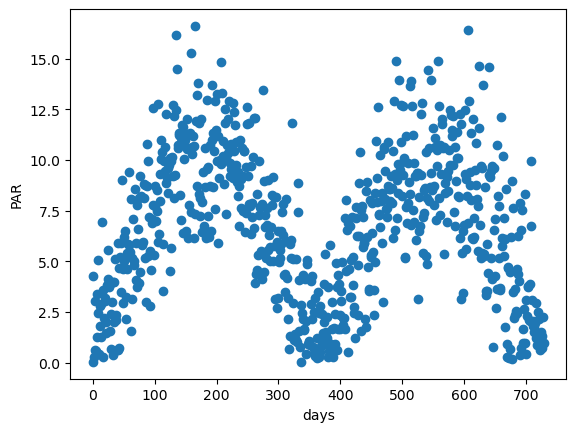

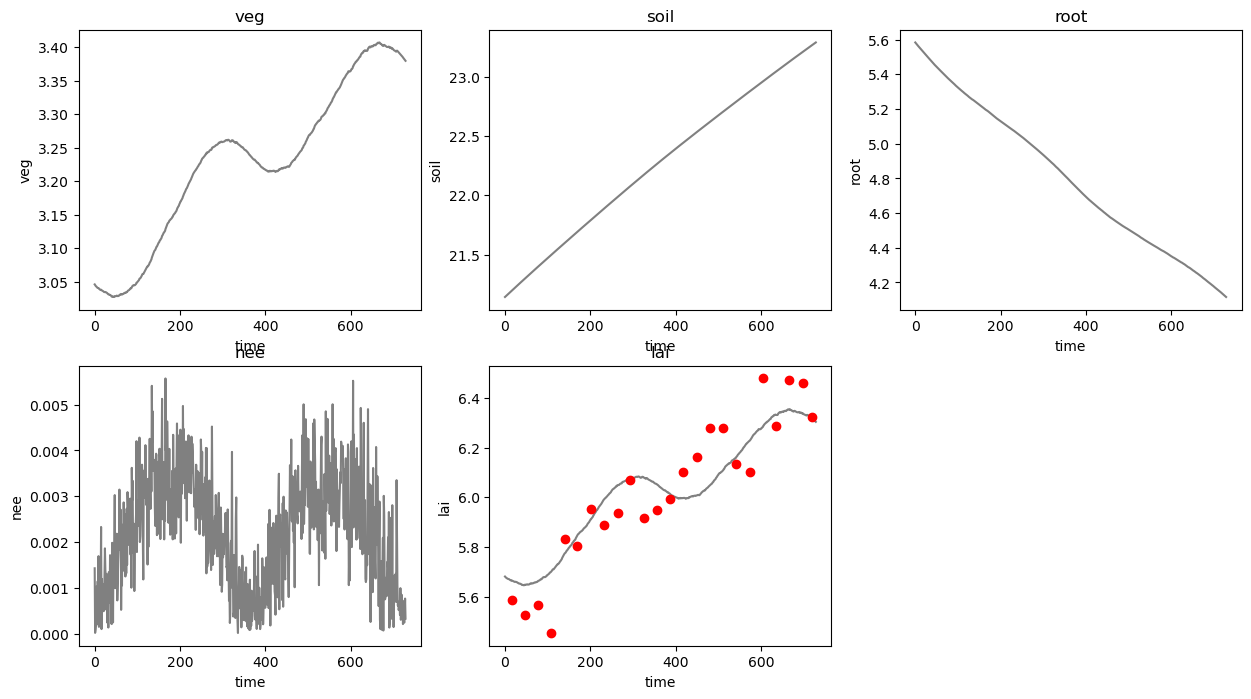

In [4]:
likelihood.plot_driver()
likelihood.plot_ground_truth()

In [ ]:
inv_prob.reset_sampler()
samp, trace_plot = inv_prob.sample_posterior(n_step=10000)

display(trace_plot)

In [ ]:
plt.hist2d(samp[:,0], samp[:,1], bins=30, cmap='Blues')
plt.plot(*likelihood.par_true, "*", color="red", markersize=12)
plt.colorbar(label='Counts per bin')
plt.xlabel('u1')
plt.ylabel('u2')
plt.title('Exact posterior')
plt.show()

/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/experiments/vsem/vsem_inv_prob.py:768: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


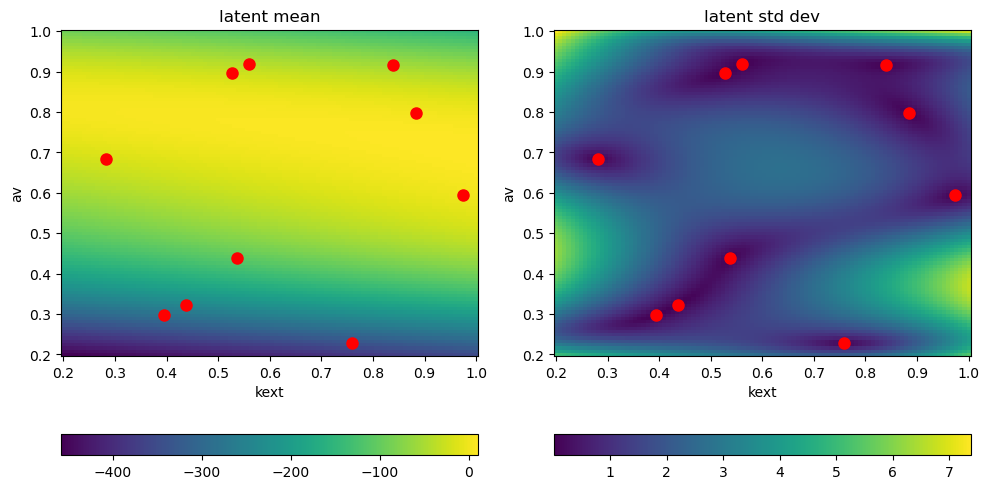

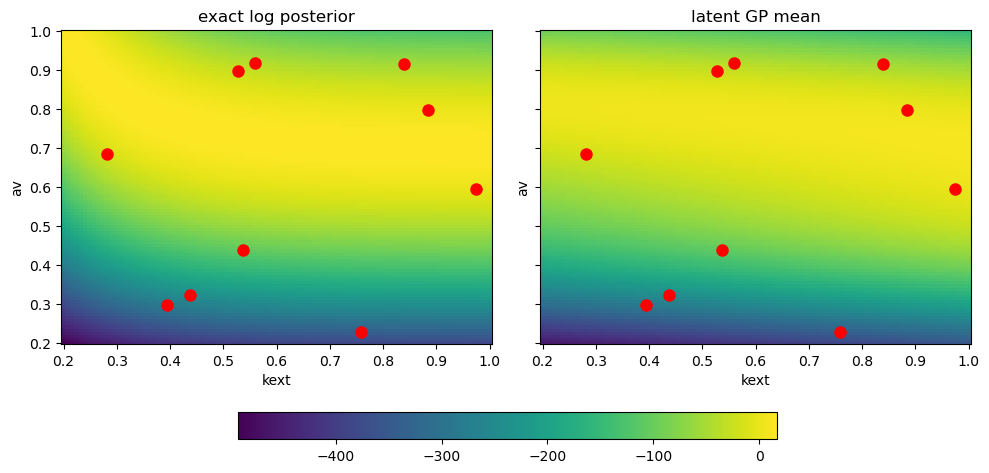

In [45]:
fig_exact, ax_exact = vsem_test.plot_exact_log_post()
fig_gp_post, ax_gp_post = vsem_test.plot_gp_pred(conditional=True, latent_pred=True, figsize=(10,5))
fig_comparison, ax_comparison = vsem_test.plot_true_vs_gp_mean(conditional=True, latent_pred=True, figsize=(10,5))

fig_comparison.subplots_adjust(bottom=0.3)
display(fig_gp_post)
display(fig_comparison)

In [5]:
log_dens_obs = lambda pred_obs: vsem_test.inv_prob.likelihood._likelihood_rv.log_p(pred_obs)
gpwrapped = gpjaxGP(vsem_test.gp_posterior, vsem_test.design, rng)
u_init = vsem_test.inv_prob.prior.sample()

rkpcn = RandomKernelPCNSampler(log_density=log_dens_obs,
                               gp=gpwrapped,
                               u_init=u_init,
                               u_prop_cov=proposal_cov,
                               pcn_cor=0.99,
                               rng=rng)

In [ ]:
rkpcn.sample(num_steps=100)

In [15]:
n_samp = len(rkpcn.trace)
u_samp = np.empty((n_samp, prior.dim))
fu_samp = np.empty(n_samp)

for i, state in enumerate(rkpcn.trace):
    u_samp[i] = state.primary['u']
    fu_samp[i] = state.primary['fu'].squeeze()

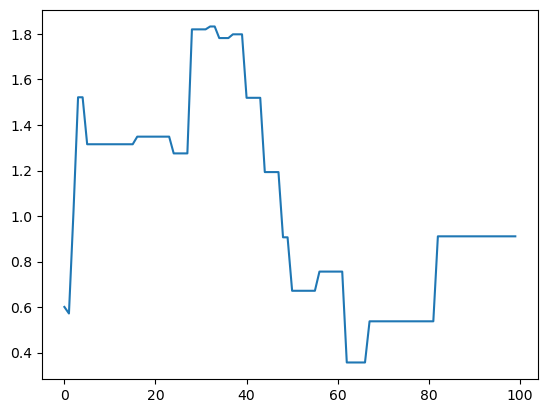

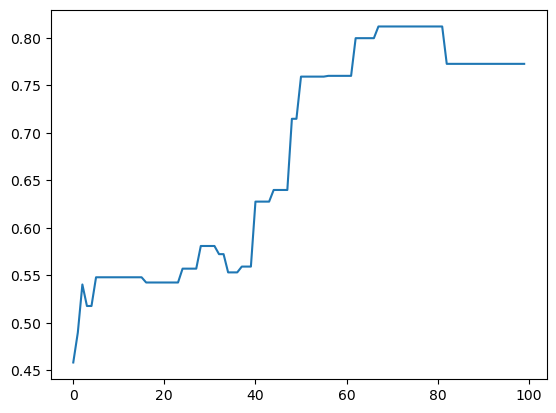

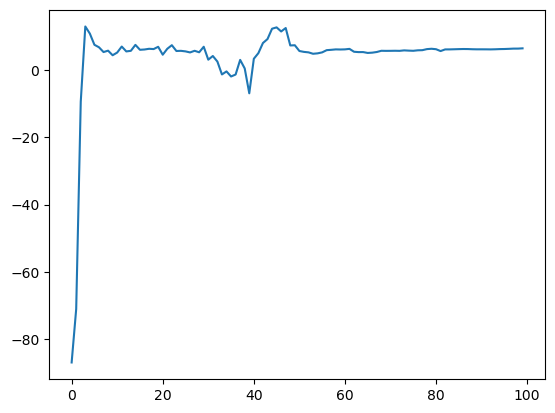

In [ ]:
plt.close()

plt.plot(u_samp[:,0])
plt.show()

plt.plot(u_samp[:,1])
plt.show()

plt.plot(fu_samp)
plt.show()

plt.close()

In [26]:
import numpy as np

def _logsumexp(a: np.ndarray, axis: int = -1) -> np.ndarray:
    """Stable log-sum-exp along `axis`. Returns array with `axis` eliminated."""
    a_max = np.max(a, axis=axis, keepdims=True)
    # If all entries are -inf, avoid NaN: keep a_max as -inf and sum_exp as 0
    sum_exp = np.sum(np.exp(a - a_max), axis=axis, keepdims=True)
    out = a_max + np.log(sum_exp)
    return np.squeeze(out, axis=axis)

def estimate_ep_grid(
    logpi_samples: np.ndarray,
    weights: np.ndarray | None = None,
    return_se: bool = True,
) -> tuple[np.ndarray, np.ndarray | None]:
    """
    Estimate E_f[ pi(u_j; f) / Z(f) ] at grid nodes using Monte Carlo samples of log-densities.

    Args:
        logpi_samples: ndarray of shape (S, M). Row s contains [ell_j(f^{(s)})]_{j=1..M},
                       where ell_j = log pi(u_j; f^{(s)}).
                       S = number of Monte Carlo samples, M = number of grid nodes.
        weights: ndarray of shape (M,), quadrature weights w_j >= 0 for approximating the
                 integral Z(f) ≈ sum_j pi(u_j;f) * w_j. If None, equal weights are used.
                 Weights must be strictly non-negative and not all zero.
        return_se: whether to return Monte Carlo standard errors (True by default).

    Returns:
        mean_p: ndarray of shape (M,), the Monte Carlo estimate of E_f[ pi(u_j;f)/Z(f) ].
        se_p: ndarray of shape (M,) giving Monte Carlo standard errors (if return_se True),
              otherwise None.

    Notes:
        - This function is numerically stable because it computes log Z(f) using log-sum-exp:
            log Z ≈ logsumexp( ell_j + log w_j ).
        - After subtracting log Z from ell_j + log w_j we exponentiate to obtain p_j(f) ∈ [0,1].
        - If memory is a concern (very large S), pass logpi_samples in batches and accumulate:
          accumulate sum_p and sum_p2; final mean = sum_p / S_total; var = (sum_p2/(S-1) - S_total/(S-1)*mean^2).
    """
    if logpi_samples.ndim != 2:
        raise ValueError("logpi_samples must be a 2D array with shape (S, M).")

    S, M = logpi_samples.shape

    if weights is None:
        weights = np.ones(M, dtype=float)
    else:
        weights = np.asarray(weights, dtype=float)
        if weights.shape != (M,):
            raise ValueError(f"weights must have shape ({M},), got {weights.shape}")
    if np.any(weights < 0):
        raise ValueError("weights must be non-negative.")
    if np.all(weights == 0):
        raise ValueError("all weights are zero (no quadrature mass).")

    # log weights (if a weight is zero, log will be -inf, which is correct)
    logw = np.log(weights)

    # Compute logZ for each f sample:
    #   logZ_s = logsumexp(ell_s + logw)
    logpi_plus_logw = logpi_samples + logw[np.newaxis, :]   # (S, M)
    logZ = _logsumexp(logpi_plus_logw, axis=1)              # (S,)

    # Compute log p_{s,j} = ell_{s,j} + log w_j - logZ_s
    logp = logpi_plus_logw - logZ[:, np.newaxis]            # shape (S, M)

    # Monte Carlo estimates: mean and (optionally) standard errors
    log_mean_p = _logsumexp(logp, axis=0) - np.log(S) # (M,)
    mean_p = np.exp(log_mean_p)                        
    se_p = None
    if return_se:
        if S > 1:
            # sample standard deviation / sqrt(S)
            std_p = np.std(np.exp(logp), axis=0, ddof=1) # TODO: improve numerical stability here
            se_p = std_p / np.sqrt(S)
        else:
            se_p = np.full(M, np.nan)

    return mean_p, se_p

In [ ]:
U_grid = vsem_test.test_grid_info["U_grid"] # (M,2)
f_grid = vsem_test.inv_prob.likelihood.par_to_obs_map(U_grid)

In [ ]:
# Sample realizations of discretized f at U_grid
import jax.random as jr
key = jr.key(123523)
S = 1000

pred = vsem_test.gp_posterior.predict(U_grid, vsem_test.design)
log_pi_u_f = pred.sample(key, (S,)) # (S, M)


In [39]:
ep_grid, ep_se_grid = estimate_ep_grid(log_pi_u_f)

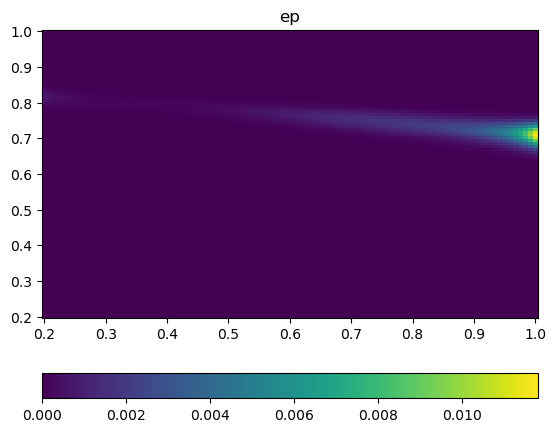

In [41]:
from vsem_inv_prob import plot_heatmap 

U1, U2 = vsem_test._get_plot_grid()
n_grid_1d = U1.shape[0]
ep_grid_reshaped = ep_grid.reshape(n_grid_1d, n_grid_1d)

mappable, fig = plot_heatmap(U1, U2, ep_grid_reshaped, title="ep")

display(fig)